Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick
Duration cpu = 6.379706621170044 s


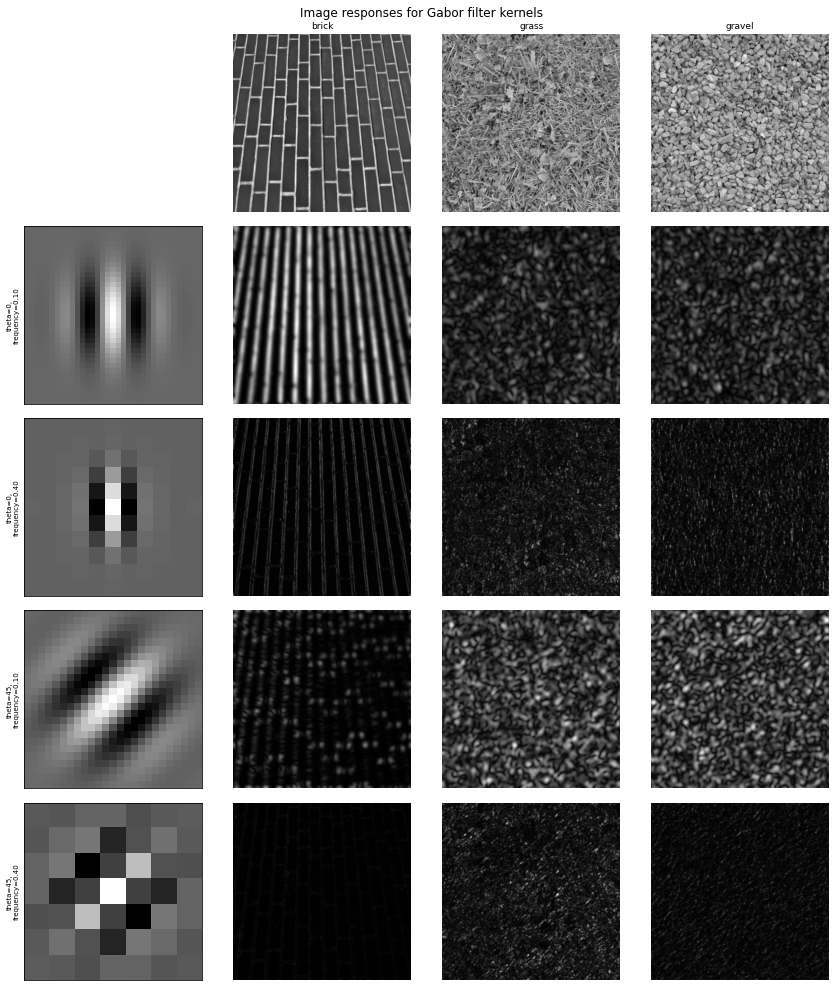

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick
Duration gpu = 0.14396929740905762 s


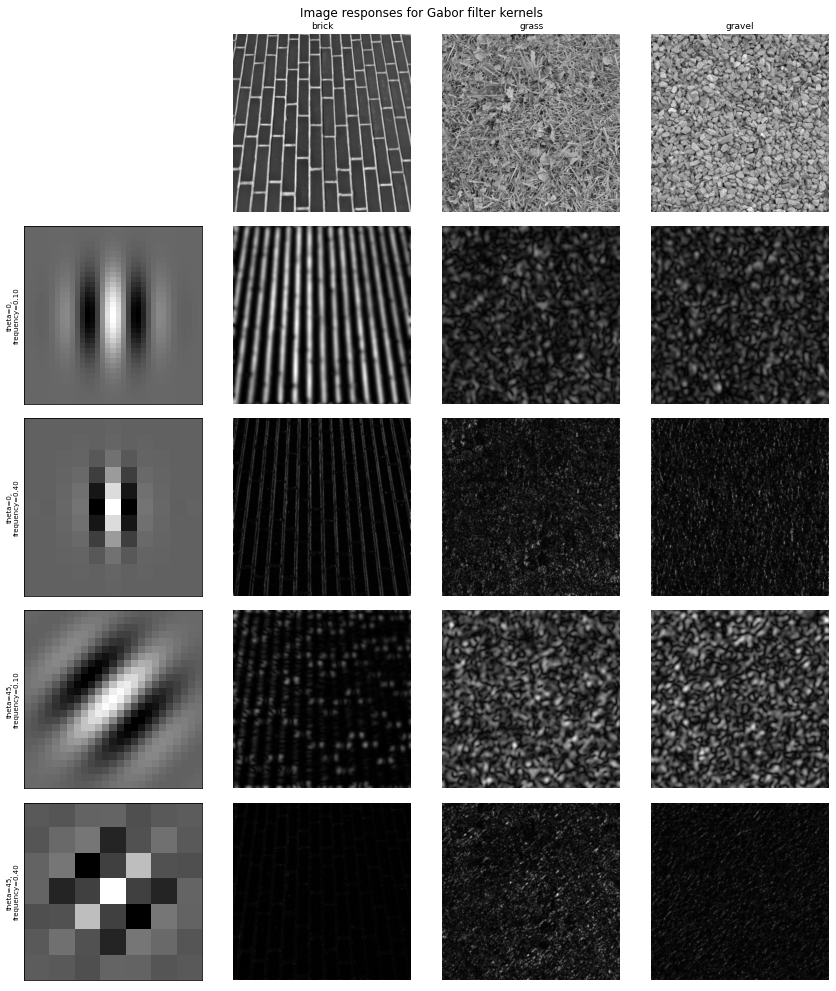

GPU Acceleration = 44.3130


In [33]:
import time

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from skimage import data

durations = {}
for use_gpu in (False, True):

    if use_gpu:
        from cupyx.scipy import ndimage as ndi
        from cucim.skimage.util import img_as_float32
        from cucim.skimage.filters import gabor_kernel
        xp = cp
        asnumpy = cp.asnumpy
        device_name = "gpu"
    else:
        from scipy import ndimage as ndi
        from skimage.util import img_as_float32
        from skimage.filters import gabor_kernel
        xp = np
        asnumpy = np.asarray
        device_name = "cpu"

        
    def compute_feats(image, kernels):
        feats = xp.zeros((len(kernels), 2), dtype=np.double)
        for k, kernel in enumerate(kernels):
            filtered = ndi.convolve(image, kernel, mode='wrap')
            feats[k, 0] = filtered.mean()
            feats[k, 1] = filtered.var()
        return feats


    def match(feats, ref_feats):
        min_error = np.inf
        min_i = None
        for i in range(ref_feats.shape[0]):
            error = xp.sum((feats - ref_feats[i, :])**2)
            if error < min_error:
                min_error = error
                min_i = i
        return min_i

    tstart = time.time()

    # prepare filter bank kernels
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = gabor_kernel(frequency, theta=theta,
                                      sigma_x=sigma, sigma_y=sigma)
                kernels.append(kernel.real)


    #shrink = (slice(0, None, 3), slice(0, None, 3))
    brick = img_as_float32(xp.asarray(data.brick()))  # [shrink]
    grass = img_as_float32(xp.asarray(data.grass()))  # [shrink]
    gravel = img_as_float32(xp.asarray(data.gravel()))  # [shrink]
    image_names = ('brick', 'grass', 'gravel')
    images = (brick, grass, gravel)

    # prepare reference features
    ref_feats = xp.zeros((3, len(kernels), 2), dtype=np.double)
    ref_feats[0, :, :] = compute_feats(brick, kernels)
    ref_feats[1, :, :] = compute_feats(grass, kernels)
    ref_feats[2, :, :] = compute_feats(gravel, kernels)

    print('Rotated images matched against references using Gabor filter banks:')

    print('original: brick, rotated: 30deg, match result: ', end='')
    feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
    print(image_names[match(feats, ref_feats)])

    print('original: brick, rotated: 70deg, match result: ', end='')
    feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
    print(image_names[match(feats, ref_feats)])

    print('original: grass, rotated: 145deg, match result: ', end='')
    feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
    print(image_names[match(feats, ref_feats)])


    def power(image, kernel):
        # Normalize images for better comparison.
        image = (image - image.mean()) / image.std()
        return xp.sqrt(ndi.convolve(image, kernel.real, mode='wrap')**2 +
                       ndi.convolve(image, kernel.imag, mode='wrap')**2)

    # Plot a selection of the filter bank kernels and their responses.
    results = []
    kernel_params = []
    for theta in (0, 1):
        theta = theta / 4. * np.pi
        for frequency in (0.1, 0.4):
            kernel = gabor_kernel(frequency, theta=theta)
            params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
            kernel_params.append(params)
            # Save kernel and the power image for each image
            results.append((kernel, xp.stack([power(img, kernel) for img in images])))
            
    dur = time.time() - tstart
    print(f"Duration {device_name} = {dur} s")
    durations[device_name] = dur

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 14))
    plt.gray()

    fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

    axes[0][0].axis('off')

    # Plot original images
    for label, img, ax in zip(image_names, images, axes[0][1:]):
        ax.imshow(asnumpy(img))
        ax.set_title(label, fontsize=9)
        ax.axis('off')

    for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
        # Plot Gabor kernel
        ax = ax_row[0]
        ax.imshow(asnumpy(kernel.real))
        ax.set_ylabel(label, fontsize=7)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plot Gabor responses with the contrast normalized for each filter
        vmin = float(powers.min())
        vmax = float(powers.max())
        for patch, ax in zip(powers, ax_row[1:]):
            ax.imshow(asnumpy(patch), vmin=vmin, vmax=vmax)
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print(f"GPU Acceleration = {durations['cpu']/durations['gpu']:0.4f}")